

>  **Image-to-Image Translation using CycleGAN Model**



In [ ]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings
import imageio

%matplotlib inline

In [ ]:
# base package
import torch
# neural network package
from torch import nn
# torchvision from image processing
import torchvision
# to load dataset from torchvision
from torchvision import datasets
# to perform transform and augmentation
from torchvision.transforms import ToTensor
import torch.nn.functional as F
# to plot images data
import matplotlib.pyplot as plt

In [ ]:
# Changed
!unzip summer2winter-yosemite.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 02:17:48.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 16:14:33.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 16:14:33.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 19:37:52.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 19:37:52.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-03 20:17:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-03 20:17:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 13:38:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 13:38:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 19:59:13.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 19:59:13.jpg  
  inflating: summer2winter_yosemite/summer/summ

In [ ]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite',
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'.
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """

    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

In [ ]:
os.makedirs("samples_cyclegan")

In [ ]:
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))

    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)

    merged = (merge_images(X, fake_Y, batch_size)*255).astype('uint8')
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = (merge_images(Y, fake_X, batch_size)*255).astype('uint8')
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

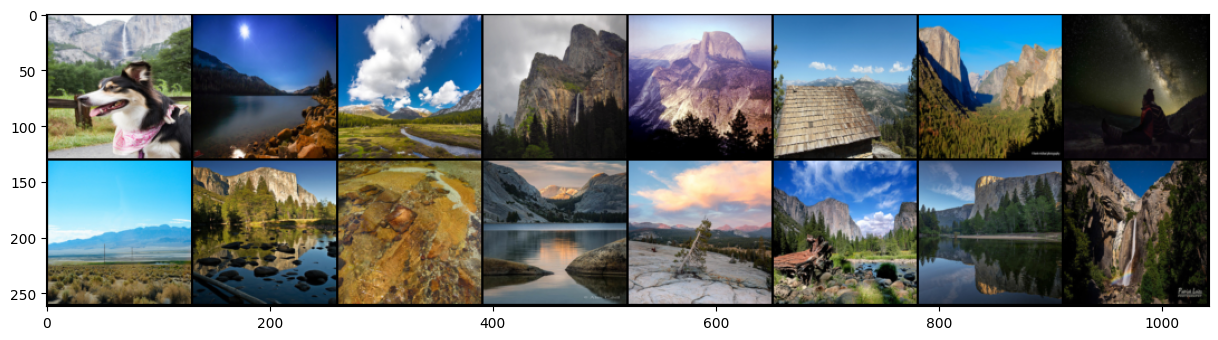

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = next(dataiter)

# show images
fig = plt.figure(figsize=(15, 8))
imshow(torchvision.utils.make_grid(images))

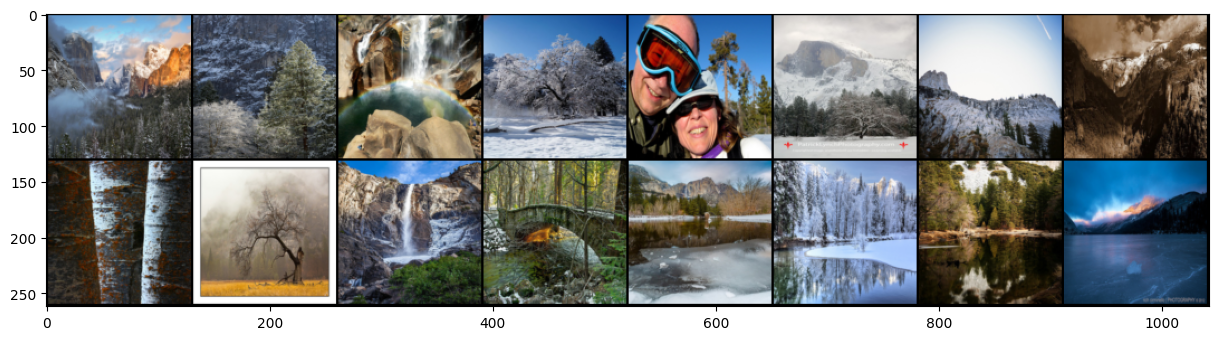

In [ ]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = next(dataiter)

# show images
fig = plt.figure(figsize=(15,8))
imshow(torchvision.utils.make_grid(images))

In [ ]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0353)
Max:  tensor(0.9882)


In [ ]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
       This function assumes that the input x is already scaled from 0-1.'''

    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9294)
Scaled max:  tensor(0.9765)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        self.layer_4 = conv(conv_dim*4,conv_dim*8,4)
        self.layer_5 = conv(conv_dim*8,1,4,1,batch_norm = False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.relu(self.layer_4(x))

        x = self.layer_5(x)
        return x

In [ ]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs

        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.layer_1 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        self.layer_2 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)

    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.layer_1(x))
        out_2 = x + self.layer_2(out_1)

        return out_2

In [ ]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
class CycleGenerator(nn.Module):

    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.layer_1 = conv(3,conv_dim,4)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        # 2. Define the resnet part of the generator
        layers = []
        for n in range(n_res_blocks):
            layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*layers)
        # 3. Define the decoder part of the generator
        self.layer_4 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_5 = deconv(conv_dim*2,conv_dim,4)
        self.layer_6 = deconv(conv_dim,3,4,batch_norm = False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
        out = F.relu(self.layer_3(out))

        out = self.res_blocks(out)

        out = F.relu(self.layer_4(out))
        out = F.relu(self.layer_5(out))
        out = F.tanh(self.layer_6(out))

        return out

In [ ]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""

    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim,n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim,n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)


    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Only CPU available.


In [ ]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()


# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layer_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out - 1)**2)


def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss
    # return weighted loss
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return loss*lambda_weight

In [ ]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr= 0.0002
beta1= 0.5
beta2= 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [ ]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y,
                  n_epochs=1000):

    print_every=10

    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = next(test_iter_X)[0]
    fixed_Y = next(test_iter_Y)[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = next(iter_X)
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = next(iter_Y)
        images_Y = scale(images_Y)

        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # 1. Compute the discriminator losses on real images
        d_x_optimizer.zero_grad()
        real_D_loss = real_mse_loss(D_X(images_X))
        # 3. Compute the fake loss for D_X
        fake_D_loss = fake_mse_loss(D_X(G_YtoX(images_Y)))
        # 4. Compute the total loss and perform backprop
        d_x_loss = real_D_loss + fake_D_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        real_D_y_loss = real_mse_loss(D_Y(images_Y))

        fake_D_y_loss = fake_mse_loss(D_Y(G_XtoY(images_X)))

        d_y_loss = real_D_y_loss + fake_D_y_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        # 1. Generate fake images that look like domain X based on real images in domain Y
        out_1 = G_YtoX(images_Y)
        # 2. Compute the generator loss based on domain X
        loss_1 = real_mse_loss(D_X(out_1))
        # 3. Create a reconstructed y
        out_2 = G_XtoY(out_1)
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        loss_2 = cycle_consistency_loss(real_im = images_Y, reconstructed_im = out_2, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        out_3 = G_XtoY(images_X)
        # 5. Add up all generator and reconstructed losses and perform backprop
        loss_3 = real_mse_loss(D_Y(out_3))
        out_4 = G_YtoX(out_3)
        loss_4 =  cycle_consistency_loss(real_im = images_X, reconstructed_im = out_4, lambda_weight=10)

        g_total_loss = loss_1 + loss_2 + loss_3 + loss_4
        g_total_loss.backward()
        g_optimizer.step()

        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))


        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [ ]:
n_epochs = 5000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.3849 | d_Y_loss: 0.8013 | g_total_loss: 9.4953
Epoch [   20/ 5000] | d_X_loss: 0.4757 | d_Y_loss: 0.4262 | g_total_loss: 8.5260
Epoch [   30/ 5000] | d_X_loss: 0.3568 | d_Y_loss: 1.1143 | g_total_loss: 6.6660
Epoch [   40/ 5000] | d_X_loss: 0.5946 | d_Y_loss: 0.2115 | g_total_loss: 6.8063
Epoch [   50/ 5000] | d_X_loss: 0.4223 | d_Y_loss: 0.4166 | g_total_loss: 6.5765
Epoch [   60/ 5000] | d_X_loss: 0.4530 | d_Y_loss: 0.4676 | g_total_loss: 5.5975
Epoch [   70/ 5000] | d_X_loss: 0.2995 | d_Y_loss: 0.6335 | g_total_loss: 6.6522
Epoch [   80/ 5000] | d_X_loss: 0.4242 | d_Y_loss: 0.4957 | g_total_loss: 4.9370
Epoch [   90/ 5000] | d_X_loss: 0.5174 | d_Y_loss: 0.4905 | g_total_loss: 5.0027
Epoch [  100/ 5000] | d_X_loss: 0.4896 | d_Y_loss: 0.4574 | g_total_loss: 4.7693
Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.3569 | d_Y_loss: 0.3864 | g_total_loss: 5.0196
Epoch [  120/ 5000]

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):

    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))

    # read in those samples
    try:
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')

    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

In [ ]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

In [ ]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

In [ ]:
# view samples at iteration 5000
view_samples(5000,'samples_cyclegan')